# Hi-Z GUNDAM NIR画像解析・モデルケース

- 2021/6/9 板 由房 (東北大)
- 2021/6/17-7/6 秋田谷　洋(千葉工大) 改訂・メモ
- 2021/7/13 秋田谷　洋 aperture photometry sky estimation test
- 2022/8/4 秋田谷　洋 (千葉工大); コード再整理

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import sys
from astropy import stats
import astroalign as aa
from astropy.io import fits
import os
import time
from sklearn.cluster import dbscan
%matplotlib inline

## 固定変数設定

In [2]:
# band name definition.
BANDS = ['o', 'j', 'h', 'k']

# ファイル名定義
BASE_DIR = './'
MODEL_DIR = 'model_fits'  # Model image directory.
DITHER_DIR = 'dither_fits'  # Dithered image directory.
FN_HEADER = 'uvissim4_'  # Model image filename header.
RESULT_DIR = 'results'  # Result files directory.

In [3]:
result_dir_path = os.path.join(BASE_DIR, RESULT_DIR)
if not os.path.isdir(result_dir_path):
    os.mkdir(result_dir_path)

## 実行記録環境準備

In [4]:
# 実行時間記録用 list.
eptime_table = []

## ディザリングデータ作成

- hzg_nirred_mkmodelimage_old.ipynb で作成済み
- dark引き, flattening, bad pix correctionなどの一次処理は完了している前提.

## 画像読み込み・シフト量計算

In [5]:
path = os.path.join(BASE_DIR, DITHER_DIR)
minmatch = 20
mindistortion = 20
n_images = 5
n_points = 100
n_sigma = 20
n_min_area = 5

start = time.time()  # 処理時間計測用.

matrix = []
counter = 0
for nb in range(len(BANDS)):
    combined_list_fn = os.path.join(BASE_DIR, RESULT_DIR, '{}.combined'.format(BANDS[nb]))
    rejected_list_fn = os.path.join(BASE_DIR, RESULT_DIR, '{}.rejectes'.format(BANDS[nb]))
    if os.path.isfile(combined_list_fn):
        os.remove(combined_list_fn)
    if os.path.isfile(rejected_list_fn):
        os.remove(rejected_list_fn)
    combined = open(combined_list_fn,'a')
    rejected = open(rejected_list_fn,'a')
    
    # 便宜上、一番最初の画像を位置のリファレンスとする。
    if counter == 0 :
        reference = os.path.join(path, '{}{}1_dthr.fits'.format(FN_HEADER, BANDS[nb]))
        ref = fits.open(reference)
        ref_sw = ref[0].data.byteswap().newbyteorder()
        combined.writelines(reference+'\n')
        
    counter += 1
        
    if nb == 0:
        first = 2
    else:
        first = 1

    for ni in range(first, n_images+1, 1):
        source = os.path.join(path, '{}{}{}_dthr.fits'.format(FN_HEADER, BANDS[nb], str(ni)))
        src = fits.open(source)
        src_sw = src[0].data.byteswap().newbyteorder()
        print("Matching {} (ref) and {} (src).".format(reference, source))
        p, (xy_src, xy_ref) = aa.find_transform(src_sw, ref_sw, max_control_points=n_points, 
                                                detection_sigma=n_sigma, min_area=n_min_area)
        matrix.append(p)
        n_matched = len(xy_src)
        print("\nTranbormation matrix:\n{}".format(p.params))
        fn_out = os.path.join(BASE_DIR, RESULT_DIR, '{}{:1s}{:1s}_aligned.fits'.format(FN_HEADER, BANDS[nb], str(ni)))
        if n_matched >= minmatch:
            print("{} stars matched.".format(n_matched))
            img_aligned, footprint = aa.apply_transform(p, src_sw, ref_sw, fill_value=0.0)
            hdu = fits.PrimaryHDU(img_aligned)
            hdulist = fits.HDUList([hdu])
            hdulist.writeto(fn_out, overwrite=True)
            combined.writelines(fn_out+'\n')
        else:
            print("Matching failed for {}.".format(source))
            rejected.writelines(source+'\n')
            
    combined.close()
    rejected.close()
    print('\n')
    
# 処理時間計測用            
elapsed_time = time.time() - start
print('elapsed_time:{0} [sec]'.format(elapsed_time))
eptime_table.append(['Image registration', elapsed_time])

Matching ./dither_fits/uvissim4_o1_dthr.fits (ref) and ./dither_fits/uvissim4_o2_dthr.fits (src).

Tranbormation matrix:
[[ 1.00002460e+00 -1.10305059e-05  9.99307306e+00]
 [ 1.10305059e-05  1.00002460e+00  9.99119959e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
95 stars matched.
Matching ./dither_fits/uvissim4_o1_dthr.fits (ref) and ./dither_fits/uvissim4_o3_dthr.fits (src).

Tranbormation matrix:
[[ 1.00002483e+00  7.11432148e-06  9.97931395e+00]
 [-7.11432148e-06  1.00002483e+00 -9.99847547e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
96 stars matched.
Matching ./dither_fits/uvissim4_o1_dthr.fits (ref) and ./dither_fits/uvissim4_o4_dthr.fits (src).

Tranbormation matrix:
[[ 1.00001722e+00 -9.61314979e-06 -1.00041017e+01]
 [ 9.61314979e-06  1.00001722e+00 -1.00066734e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
97 stars matched.
Matching ./dither_fits/uvissim4_o1_dthr.fits (ref) and ./dither_fits/uvissim4_o5_dthr.fits (src).

Tranbormation matrix:


### memo (HA)
* 現状、整数シフト画像のため、matrixは当然整数シフトのみ、回転なしになっている。(HZGの姿勢要請でも並進のみの補正で良いことにしている)
* 配列の定義
    * https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.SimilarityTransform
    <pre>
    X = a0 * x - b0 * y + a1 =
    = s * x * cos(rotation) - s * y * sin(rotation) + a1
    Y = b0 * x + a0 * y + b1 =
    = s * x * sin(rotation) + s * y * cos(rotation) + b1
    where s is a scale factor and the homogeneous transformation matrix is:
    [[a0  b0  a1]
    [b0  a0  b1]
    [0   0    1]]
    </pre>

## 重ね合わせ
- https://nbviewer.jupyter.org/gist/mwcraig/06060d789cc298bbb08e

In [6]:
from astropy import units as u
from ccdproc import ImageFileCollection, CCDData, Combiner, combine

# 処理時間計測用.
start = time.time()

for nb in range(len(BANDS)):
    fn_out = os.path.join(BASE_DIR, RESULT_DIR, '{}_combined.fits'.format(BANDS[nb]))
    fn_list = os.path.join(BASE_DIR, RESULT_DIR, '{}.combined'.format(BANDS[nb]))
    if os.path.isfile(fn_list):
        if os.path.isfile(fn_list):
            ncombine = sum([1 for _ in open(fn_list)])  # H. A. (2021/06/17)
        if ncombine > 3 :
            print('Combining {} images in {}.'.format(ncombine, fn_list))
            images = np.loadtxt(fn_list, dtype=str)
            img = ImageFileCollection(filenames=images.tolist())
            combine1 = []
            for hdu, fname in img.hdus(return_fname=True):
                meta = hdu.header
                #meta['filename'] = fname
                combine1.append(CCDData(data=hdu.data, meta=meta, unit=u.adu))
            combine2 = Combiner(combine1)
            master_image = combine2.median_combine()
            hdu = fits.PrimaryHDU(master_image)
            hdulist = fits.HDUList([hdu])
            hdulist.writeto(fn_out, overwrite=True)
        else :
            print('Too few images in {}.'.format(fn_list))

# 処理時間計測用.
elapsed_time = time.time() - start
print ('elapsed_time:{0} [sec]'.format(elapsed_time))
eptime_table.append(['Combining', elapsed_time])

Combining 5 images in ./results/o.combined.
Combining 5 images in ./results/j.combined.
Combining 5 images in ./results/h.combined.
Combining 5 images in ./results/k.combined.
elapsed_time:1.4881658554077148 [sec]


## photometry
### references.
- JWST sample
  - https://spacetelescope.github.io/jdat_notebooks/notebooks/psf_photometry/NIRCam_PSF_Photometry_Example.html
- PSF fit
  - https://photutils.readthedocs.io/en/stable/psf.html
- Aperture
  - https://photutils.readthedocs.io/en/stable/aperture.html

### Aperture photometry

In [7]:
from photutils.detection import DAOStarFinder
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.centroids import centroid_2dg
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from astropy.stats import sigma_clipped_stats
import astropy.units as u
from astropy.io import ascii

# データが無かったときに入れる適当な数
NO_DATA = -999.999

bkgbkg = MMMBackground()
bkgrms = MADStdBackgroundRMS()

# 処理時間計測用.
start = time.time()

for i in range (len(BANDS)):
    fn_combined = os.path.join(BASE_DIR, RESULT_DIR, '{}_combined.fits'.format(BANDS[i]))
    image = fits.getdata(fn_combined)

    # not used below
    bkg = bkgbkg(image)  # (A) BG by the DAOPHOT MMM algorithm.
    # http://astroa.physics.metu.edu.tr/MANUALS/daophot_manual/help_daophot.html

    std = bkgrms(image)  # (A) BG rms by median absolute deviation (MAD).
    #                          MAD = median(Xi - median(Xi))
    #                          sigma = 1.4826 {MAD}
    daofind = DAOStarFinder(fwhm=2.5, threshold=3.*std)
    # https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html
    sources = daofind(image)
    # (A) ?? same as daofind.find_stars(image)
    
    # (A) ndarrayの転置
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    
    apertures = CircularAperture(positions, r=7.5)
    annulus_apertures = CircularAnnulus(positions, r_in=8, r_out=13)
    annulus_masks = annulus_apertures.to_mask(method='center')

    rawflux = aperture_photometry(image, apertures)

    # Local backgroundでPhotometry
    bkg_median = []
    for mask in annulus_masks:
        annulus_data = mask.multiply(image)
        annulus_data_1d = annulus_data[mask.data > 0]
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        bkg_median.append(median_sigclip)
        
    bkg_median = np.array(bkg_median)  # (A) Median calculation; time consuming process
    rawflux['annulus_median'] = bkg_median
    rawflux['aper_bkg'] = bkg_median*apertures.area
    rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg'] 
    
    rawflux['aper_bkg'][np.where(rawflux['aper_bkg'] <= 0)] = NO_DATA
    rawflux['final_phot'][np.where(rawflux['final_phot'] <= 0)] = NO_DATA
    rawflux['final_phot'][np.where(rawflux['aper_bkg'] <= 0)] = NO_DATA
    
    for col in rawflux.colnames:
        rawflux[col].info.format = '%.8g'  # for consistent table output
        
    fn_csv_out = os.path.join(BASE_DIR, RESULT_DIR, '{}.csv'.format(BANDS[i]))
    ascii.write(rawflux, fn_csv_out, overwrite=True, format='csv')

#処理時間計測用.
elapsed_time = time.time() - start
print ('elapsed_time:{0} [sec]'.format(elapsed_time))
eptime_table.append(['Aperture Photometry', elapsed_time])

elapsed_time:9.326416969299316 [sec]


## バンドマージング

## 受かった星の座標をマージして、座標カタログを作る。
## 一つのバンドでも受かってれば残る。
## DBSCANで同じ星を認識する。探索半径はradiusで設定。

### memo (HA)
* 極端に青い天体、赤い天体がどうなるか？
1. pixel が充分離れて分離されているとき
  * それぞれ独立な天体としてカタログされる
2. pixelがとなりあって連なっているとき
  * 同じ1つの天体としてみなされる

* 以後の測光も同じように評価される
  * どのみち画像で分離できないのだからどうしようもないか

In [8]:
radius = 0.5  # Matching radius (pix).

# 処理時間計測用.
start = time.time()

ph_data = {}  # Dictionary for pandas DataFrame data.
xy_data = {}  # Dictionary for xy centeral coordinate data.

for band in BANDS:
    # DataFrame データ型 (of pandas)に読み込む.
    ph_data[band] = pd.read_csv(os.path.join(BASE_DIR, RESULT_DIR, '{}.csv'.format(band)))
    # 中心座標を抽出
    xy_data[band] = ph_data[band].loc[:, ['xcenter', 'ycenter']]
    # 行は全部(:), 列が'xcenter', 'ycenter'の要素を抽出.
    # 返り値はpandas.core.frame.DataFrame.

xyall = np.vstack([xy_data[key] for key in xy_data.keys()])  # (A) 結合, ndarrayにcast.
print(len(xyall))

xy=[]
clusters = dbscan(np.sort(xyall), eps=radius, min_samples=1)[1]
# sklearn.cluster.dbscan
# https://scikit-learn.org/stable/modules/generated/dbscan-function.html

for c in np.unique(clusters):
    #print(xyall[clusters==c])
    #print(np.mean(xyall[clusters==c], axis=0))
    xy.append(np.mean(xyall[clusters==c], axis=0))

print(len(xy))

catalog = pd.DataFrame(data=xy, columns=["xref", "yref"])

# 処理時間計測用.
elapsed_time = time.time() - start
print ('elapsed_time:{0} [sec]'.format(elapsed_time)) 
eptime_table.append(['Band Marging', elapsed_time])

23960
7994
elapsed_time:0.5014164447784424 [sec]


In [9]:
# Result check 1.
xyall

array([[ 11.351274 ,   1.3511212],
       [311.9957   ,   1.0428753],
       [791.99984  ,   1.0465766],
       ...,
       [275.01078  , 976.44916  ],
       [453.09654  , 977.05999  ],
       [746.68493  , 977.72226  ]])

In [10]:
# Result check 2.
np.sort(xyall)

array([[  1.3511212,  11.351274 ],
       [  1.0428753, 311.9957   ],
       [  1.0465766, 791.99984  ],
       ...,
       [275.01078  , 976.44916  ],
       [453.09654  , 977.05999  ],
       [746.68493  , 977.72226  ]])

## KDTreeを使ってカタログを作る

In [11]:
#https://myenigma.hatenablog.com/entry/2020/06/14/205753#scipyspatialcKDTreeの使い方
from scipy.spatial import cKDTree

def distance(xy1, xy2):
    '''距離測定'''
    r = np.sqrt((xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2)
    return r


start = time.time()

# grand xy vs. o-band
kd_tree = cKDTree(xy_data['o'])
indexes = kd_tree.query_ball_point(xy, radius)
adu = []
for i in range(len(indexes)):
    if indexes[i] != []:
        rmin = 5e10
        for j in range(len(indexes[i])): # 探索半径内に複数入った場合は最近傍の物を採用
            k = (indexes[i])[j]
            r = distance(xy[i], np.array(xy_data['o'])[k])
            if r < rmin:
                rmin = r
                idx = k    
        #writeout = '{0:10.5f} {1:10.5f} {2:12.3f}'.format(xy[i][0], xy[i][1], odata['final_phot'][idx])
        #print(writeout)
        adu.append(ph_data['o']['final_phot'][idx])
    else:
        #writeout = '{0:10.5f} {1:10.5f} {2:12.3f}'.format(xy[i][0], xy[i][1], NO_DATA)
        #print(writeout)
        adu.append(NO_DATA)      
catalog['o_adu'] = adu

# grand xy vs. j-band
kd_tree = cKDTree(xy_data['j'])
indexes = kd_tree.query_ball_point(xy, radius)
adu = []
for i in range(len(indexes)):
    if indexes[i] != []:
        rmin = 5e10
        for j in range(len(indexes[i])): # 探索半径内に複数入った場合は最近傍の物を採用
            k = (indexes[i])[j]
            r = distance(xy[i], np.array(xy_data['j'])[k])
            if r < rmin:
                rmin = r
                idx = k    
        #writeout = '{0:10.5f} {1:10.5f} {2:12.3f}'.format(xy[i][0], xy[i][1], jdata['final_phot'][idx])
        #print(writeout)
        adu.append(ph_data['j']['final_phot'][idx])
    else:
        #writeout = '{0:10.5f} {1:10.5f} {2:12.3f}'.format(xy[i][0], xy[i][1], NO_DATA)
        #print(writeout)
        adu.append(NO_DATA)      
catalog['j_adu'] = adu

# grand xy vs. h-band
kd_tree = cKDTree(xy_data['h'])
indexes = kd_tree.query_ball_point(xy, radius)
adu = []
for i in range(len(indexes)):
    if indexes[i] != []:
        rmin = 5e10
        for j in range(len(indexes[i])): # 探索半径内に複数入った場合は最近傍の物を採用
            k = (indexes[i])[j]
            r = distance(xy[i], np.array(xy_data['h'])[k])
            if r < rmin:
                rmin = r
                idx = k    
        #writeout = '{0:10.5f} {1:10.5f} {2:12.3f}'.format(xy[i][0], xy[i][1], hdata['final_phot'][idx])
        #print(writeout)
        adu.append(ph_data['h']['final_phot'][idx])
    else:
        #writeout = '{0:10.5f} {1:10.5f} {2:12.3f}'.format(xy[i][0], xy[i][1], NO_DATA)
        #print(writeout)
        adu.append(NO_DATA)      
catalog['h_adu'] = adu

# grand xy vs. k-band
kd_tree = cKDTree(xy_data['k'])
indexes = kd_tree.query_ball_point(xy, radius)
adu = []
for i in range(len(indexes)):
    if indexes[i] != []:
        rmin = 5e10
        for j in range(len(indexes[i])): # 探索半径内に複数入った場合は最近傍の物を採用
            k = (indexes[i])[j]
            r = distance(xy[i], np.array(xy_data['k'])[k])
            if r < rmin:
                rmin = r
                idx = k    
        #writeout = '{0:10.5f} {1:10.5f} {2:12.3f}'.format(xy[i][0], xy[i][1], hdata['final_phot'][idx])
        #print(writeout)
        adu.append(ph_data['k']['final_phot'][idx])
    else:
        #writeout = '{0:10.5f} {1:10.5f} {2:12.3f}'.format(xy[i][0], xy[i][1], NO_DATA)
        #print(writeout)
        adu.append(NO_DATA)      
catalog['k_adu'] = adu

# 処理時間計測用.
elapsed_time = time.time() - start
print ('elapsed_time:{0} [sec]'.format(elapsed_time))
eptime_table.append(['Catarog Creation', elapsed_time])

elapsed_time:0.58811354637146 [sec]


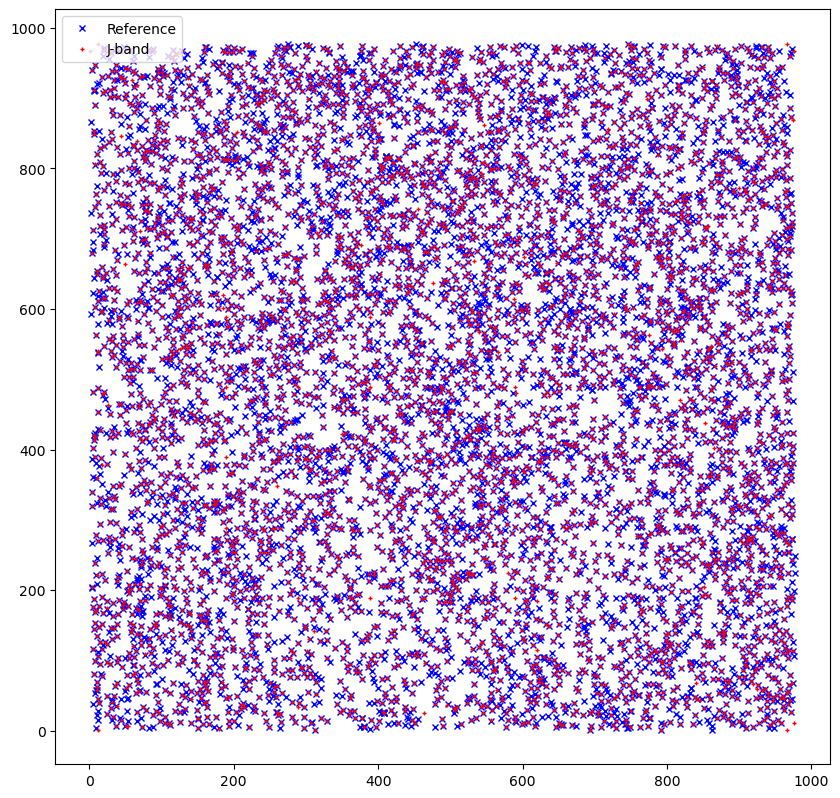

In [12]:
# Sample plot.
band = 'j'
plt.figure(figsize=(10, 10), dpi=100)
plt.plot(catalog['xref'], catalog['yref'], "xb", ms=4, label='Reference')
plt.plot(ph_data[band]['xcenter'], ph_data[band]['ycenter'], "+r", ms=3, label='J-band')
plt.legend()
plt.show()

### 全画像強制測光
- 現バージョンでは、正方形(3x3 pix)ではなく円形開口測光を用いているので注意. (要求実装では3x3 pix正方形測光とする). (2022/8/4 H.A.)

/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:935: FutureWarning: The input object of type 'SimilarityTransform' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'SimilarityTransform', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, order=order, subok=subok, copy=True)
/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:935: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


#Band: o, frame No.: 0
./dither_fits/uvissim4_o1_dthr.fits
7994 7994
Statistics:
BG from all pixs 9027.34
BG w/ clipping:  9017.98 +/- 15.04 (from photon stat. 5.23)
BG w/o clipping: 9025.35 +/- 19.12
BG diff:         -7.21 +/- 6.43 (from photon stat. 7.39)
    (%):         -0.08 +/- 0.07
BG diff all - aps: 1.99


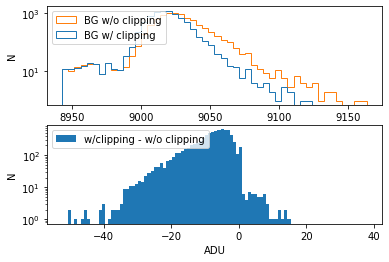

#Band: o, frame No.: 1
./dither_fits/uvissim4_o2_dthr.fits
7994 7994
Statistics:
BG from all pixs 9027.61
BG w/ clipping:  9018.11 +/- 14.04 (from photon stat. 5.23)
BG w/o clipping: 9025.78 +/- 18.07
BG diff:         -7.29 +/- 6.33 (from photon stat. 7.39)
    (%):         -0.08 +/- 0.07
BG diff all - aps: 1.83


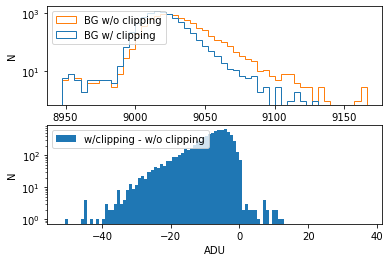

#Band: o, frame No.: 2
./dither_fits/uvissim4_o3_dthr.fits
7994 7994
Statistics:
BG from all pixs 9027.30
BG w/ clipping:  9018.02 +/- 14.04 (from photon stat. 5.23)
BG w/o clipping: 9025.98 +/- 18.13
BG diff:         -7.42 +/- 6.40 (from photon stat. 7.39)
    (%):         -0.08 +/- 0.07
BG diff all - aps: 1.32


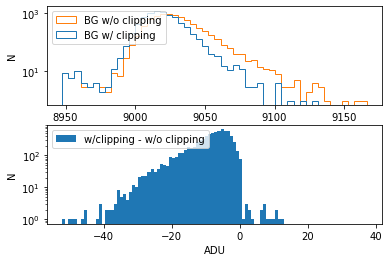

#Band: o, frame No.: 3
./dither_fits/uvissim4_o4_dthr.fits
7994 7994
Statistics:
BG from all pixs 9027.24
BG w/ clipping:  9018.24 +/- 13.96 (from photon stat. 5.23)
BG w/o clipping: 9025.61 +/- 17.97
BG diff:         -7.21 +/- 6.36 (from photon stat. 7.39)
    (%):         -0.08 +/- 0.07
BG diff all - aps: 1.63


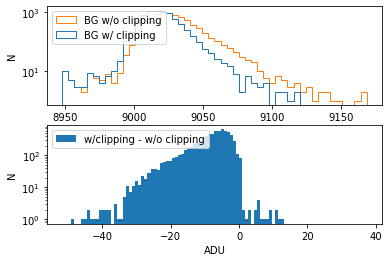

#Band: o, frame No.: 4
./dither_fits/uvissim4_o5_dthr.fits
7994 7994
Statistics:
BG from all pixs 9027.29
BG w/ clipping:  9017.95 +/- 13.81 (from photon stat. 5.23)
BG w/o clipping: 9025.49 +/- 17.84
BG diff:         -7.23 +/- 6.31 (from photon stat. 7.39)
    (%):         -0.08 +/- 0.07
BG diff all - aps: 1.80


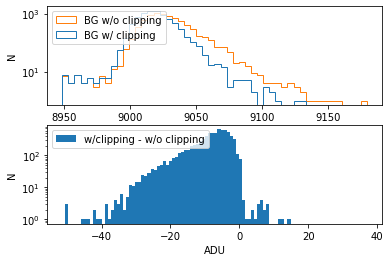

#Band: j, frame No.: 0
./dither_fits/uvissim4_j1_dthr.fits
7994 7994
Statistics:
BG from all pixs 3678.89
BG w/ clipping:  3672.52 +/- 9.83 (from photon stat. 3.34)
BG w/o clipping: 3677.76 +/- 12.43
BG diff:         -5.05 +/- 4.21 (from photon stat. 4.72)
    (%):         -0.14 +/- 0.11
BG diff all - aps: 1.12


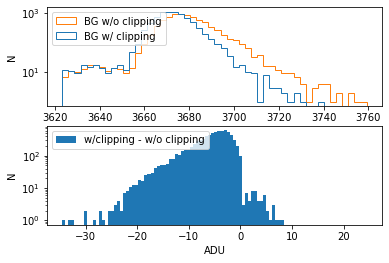

#Band: j, frame No.: 1
./dither_fits/uvissim4_j2_dthr.fits
7994 7994
Statistics:
BG from all pixs 3678.98
BG w/ clipping:  3672.72 +/- 9.09 (from photon stat. 3.34)
BG w/o clipping: 3678.05 +/- 11.73
BG diff:         -5.11 +/- 4.19 (from photon stat. 4.72)
    (%):         -0.14 +/- 0.11
BG diff all - aps: 0.93


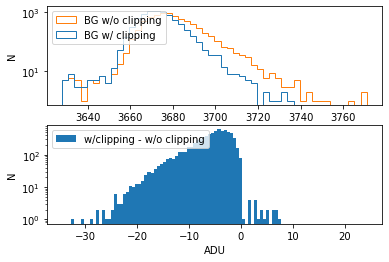

#Band: j, frame No.: 2
./dither_fits/uvissim4_j3_dthr.fits
7994 7994
Statistics:
BG from all pixs 3678.90
BG w/ clipping:  3672.60 +/- 9.19 (from photon stat. 3.34)
BG w/o clipping: 3678.26 +/- 11.83
BG diff:         -5.24 +/- 4.20 (from photon stat. 4.72)
    (%):         -0.14 +/- 0.11
BG diff all - aps: 0.63


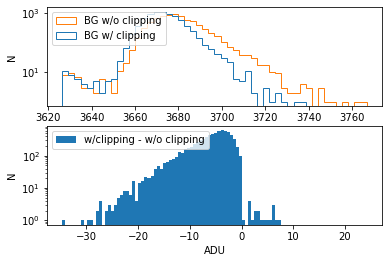

#Band: j, frame No.: 3
./dither_fits/uvissim4_j4_dthr.fits
7994 7994
Statistics:
BG from all pixs 3678.78
BG w/ clipping:  3672.59 +/- 8.99 (from photon stat. 3.34)
BG w/o clipping: 3677.90 +/- 11.62
BG diff:         -5.11 +/- 4.20 (from photon stat. 4.72)
    (%):         -0.14 +/- 0.11
BG diff all - aps: 0.87


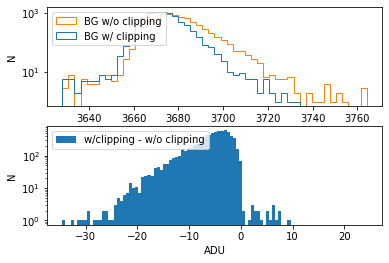

#Band: j, frame No.: 4
./dither_fits/uvissim4_j5_dthr.fits
7994 7994
Statistics:
BG from all pixs 3678.82
BG w/ clipping:  3672.53 +/- 8.93 (from photon stat. 3.34)
BG w/o clipping: 3677.84 +/- 11.55
BG diff:         -5.06 +/- 4.21 (from photon stat. 4.72)
    (%):         -0.14 +/- 0.11
BG diff all - aps: 0.99


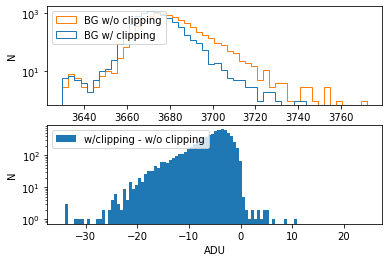

#Band: h, frame No.: 0
./dither_fits/uvissim4_h1_dthr.fits
7994 7994
Statistics:
BG from all pixs 1712.22
BG w/ clipping:  1707.37 +/- 7.10 (from photon stat. 2.28)
BG w/o clipping: 1711.47 +/- 9.01
BG diff:         -3.92 +/- 3.08 (from photon stat. 3.22)
    (%):         -0.23 +/- 0.18
BG diff all - aps: 0.75


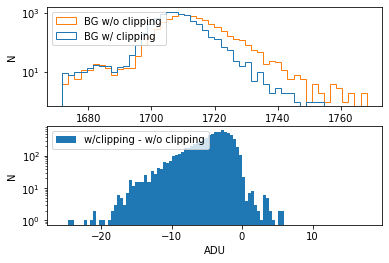

#Band: h, frame No.: 1
./dither_fits/uvissim4_h2_dthr.fits
7994 7994
Statistics:
BG from all pixs 1712.25
BG w/ clipping:  1707.50 +/- 6.69 (from photon stat. 2.28)
BG w/o clipping: 1711.59 +/- 8.66
BG diff:         -3.97 +/- 3.10 (from photon stat. 3.22)
    (%):         -0.23 +/- 0.18
BG diff all - aps: 0.66


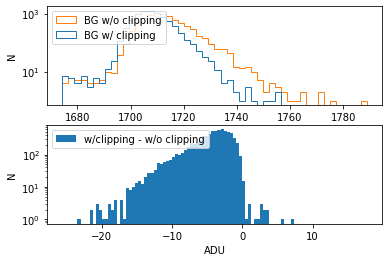

#Band: h, frame No.: 2
./dither_fits/uvissim4_h3_dthr.fits
7994 7994
Statistics:
BG from all pixs 1712.19
BG w/ clipping:  1707.51 +/- 6.69 (from photon stat. 2.28)
BG w/o clipping: 1711.76 +/- 8.65
BG diff:         -4.00 +/- 3.10 (from photon stat. 3.22)
    (%):         -0.23 +/- 0.18
BG diff all - aps: 0.43


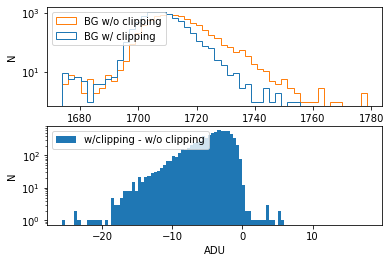

#Band: h, frame No.: 3
./dither_fits/uvissim4_h4_dthr.fits
7994 7994
Statistics:
BG from all pixs 1712.15
BG w/ clipping:  1707.47 +/- 6.56 (from photon stat. 2.28)
BG w/o clipping: 1711.57 +/- 8.47
BG diff:         -3.98 +/- 3.04 (from photon stat. 3.22)
    (%):         -0.23 +/- 0.18
BG diff all - aps: 0.58


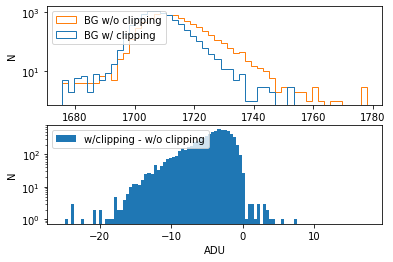

#Band: h, frame No.: 4
./dither_fits/uvissim4_h5_dthr.fits
7994 7994
Statistics:
BG from all pixs 1712.12
BG w/ clipping:  1707.38 +/- 6.56 (from photon stat. 2.28)
BG w/o clipping: 1711.50 +/- 8.46
BG diff:         -3.93 +/- 3.05 (from photon stat. 3.22)
    (%):         -0.23 +/- 0.18
BG diff all - aps: 0.61


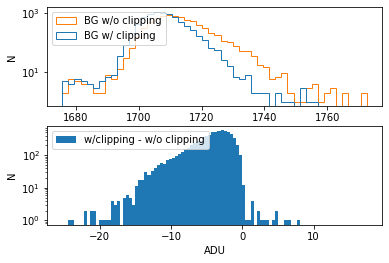

#Band: k, frame No.: 0
./dither_fits/uvissim4_k1_dthr.fits
7994 7994
Statistics:
BG from all pixs 1135.41
BG w/ clipping:  1131.38 +/- 5.82 (from photon stat. 1.85)
BG w/o clipping: 1134.93 +/- 7.28
BG diff:         -3.39 +/- 2.47 (from photon stat. 2.62)
    (%):         -0.30 +/- 0.22
BG diff all - aps: 0.48


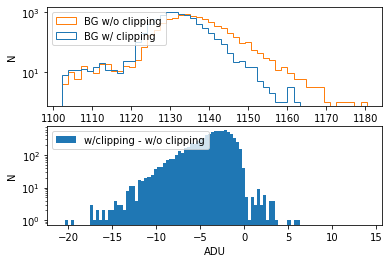

#Band: k, frame No.: 1
./dither_fits/uvissim4_k2_dthr.fits
7994 7994
Statistics:
BG from all pixs 1135.44
BG w/ clipping:  1131.49 +/- 5.44 (from photon stat. 1.85)
BG w/o clipping: 1135.12 +/- 6.97
BG diff:         -3.44 +/- 2.48 (from photon stat. 2.62)
    (%):         -0.30 +/- 0.22
BG diff all - aps: 0.32


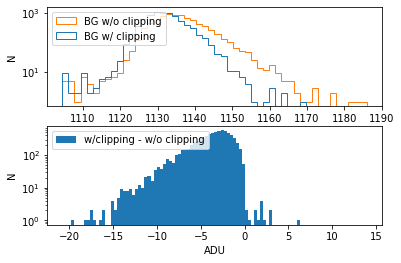

#Band: k, frame No.: 2
./dither_fits/uvissim4_k3_dthr.fits
7994 7994
Statistics:
BG from all pixs 1135.37
BG w/ clipping:  1131.43 +/- 5.44 (from photon stat. 1.85)
BG w/o clipping: 1135.15 +/- 6.97
BG diff:         -3.46 +/- 2.48 (from photon stat. 2.62)
    (%):         -0.31 +/- 0.22
BG diff all - aps: 0.22


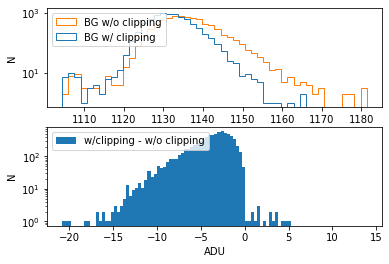

#Band: k, frame No.: 3
./dither_fits/uvissim4_k4_dthr.fits
7994 7994
Statistics:
BG from all pixs 1135.35
BG w/ clipping:  1131.44 +/- 5.34 (from photon stat. 1.85)
BG w/o clipping: 1135.01 +/- 6.80
BG diff:         -3.47 +/- 2.46 (from photon stat. 2.62)
    (%):         -0.31 +/- 0.22
BG diff all - aps: 0.34


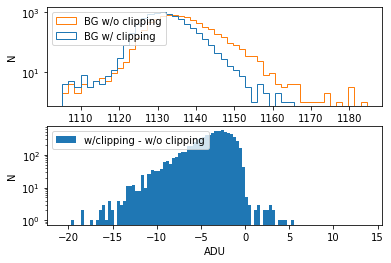

#Band: k, frame No.: 4
./dither_fits/uvissim4_k5_dthr.fits
7994 7994
Statistics:
BG from all pixs 1135.34
BG w/ clipping:  1131.47 +/- 5.31 (from photon stat. 1.85)
BG w/o clipping: 1135.02 +/- 6.79
BG diff:         -3.39 +/- 2.48 (from photon stat. 2.62)
    (%):         -0.30 +/- 0.22
BG diff all - aps: 0.32


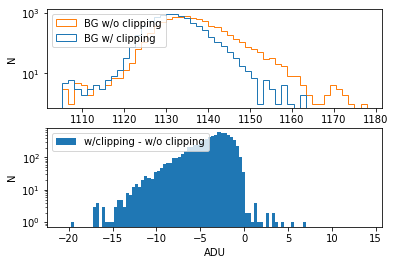

elapsed_time:54.066112995147705 [sec]


In [13]:
from astropy.stats import sigma_clip

# 処理時間計測用.
start = time.time()

inverse = np.copy(matrix)

R_AP = 7.5  # (A) aperture radius
R_IN = 8.0  # (A) sky inner radius
R_OUT = 13.0  # (A) sky ourter radius

for i in range(len(BANDS)):
    for j in range(n_images):
        print('#Band: {}, frame No.: {}'.format(BANDS[i], j))
        fn_in = os.path.join(BASE_DIR, DITHER_DIR, '{}{}{}_dthr.fits'.format(FN_HEADER, BANDS[i], str(j+1)))
        print(fn_in)
        image = fits.getdata(fn_in)
        if i+j == 0:
            #positions = np.transpose((catalog['xref'], catalog['yref']))
            positions = xy
        else:
            k = i*n_images + j - 1
            #print(inverse[k].params)
            (inverse[k].params)[0,1] *= -1
            (inverse[k].params)[0,2] *= -1
            (inverse[k].params)[1,0] *= -1
            (inverse[k].params)[1,2] *= -1
            # print(inverse[k].params)
            positions = inverse[k](xy)
            
        apertures = CircularAperture(positions, r=R_AP)
        annulus_apertures = CircularAnnulus(positions, r_in=R_IN, r_out=R_OUT)
        annulus_masks = annulus_apertures.to_mask(method='center')
        rawflux = aperture_photometry(image, apertures)
        
        # Local backgroundでPhotometry
        bkg_median = []  # (A) background (median & sigma-clipping)
        bkg_median_woclp = []  # (A) background (only median)
        bkg_median_for_stat = []  # (A) background (median & sigma-clipping)
        bkg_median_woclp_for_stat = []  # (A) background (only median)
        
        for mask in annulus_masks:
            annulus_data = mask.multiply(image)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)  # (A) Sigma clipping (time consuming)
            median = np.median(annulus_data_1d)  # (A) median calculation
            bkg_median.append(median_sigclip)  # (A) contd.
            bkg_median_woclp.append(median)
            #if median_sigclip > 800.0:  # reject outliers
            #    bkg_median_for_stat.append(median_sigclip)
            #    bkg_median_woclp_for_stat.append(median)

        bkg_median = np.array(bkg_median)
        bkg_median_woclp = np.array(bkg_median_woclp)  # (A) convert to ndarray
        bkg_median_for_stat = sigma_clip(np.array(bkg_median), 
                                         sigma_lower=5, sigma_upper=10)
        #bkg_median_woclp_for_stat = sigma_clip(np.array(bkg_median_woclp), 
        #                                       masked=False, sigma_lower=5, sigma_upper=10)  # (A) convert to ndarray
        bkg_median_woclp_for_stat = np.ma.array(bkg_median_woclp, mask=bkg_median_for_stat.mask)
        print(len(bkg_median_for_stat.data), len(bkg_median_woclp_for_stat))
        bkg_median_for_stat = bkg_median_for_stat.compressed()
        bkg_median_woclp_for_stat = bkg_median_woclp_for_stat.compressed()
        bkg_diff = bkg_median_for_stat - bkg_median_woclp_for_stat  # (A) Differentian between skys clipped and not-clipped
        #std_bkg_diff_tmp = np.std(bkg_median)
        #bkg_diff = bkg_diff_tmp[bkg_diff_tmp < 5.0*std_bkg_diff_tmp and bkg_diff_tmp > -5.0*std_bkg_diff_tmp]
        #_, bkg_diff, _ = sigma_clipped_stats(bkg_diff_tmp, sigma=5, 
        #                                     maxiters=1)  # (A) sigma clipping
        median_bkg_median = np.median(bkg_median_for_stat)
        # statistics
        median_bkg_median_woclp = np.median(bkg_median_woclp_for_stat)
        median_bkg_diff = np.median(bkg_diff)
        median_bkg_median = np.median(bkg_median_for_stat)
        std_bkg_median_woclp = np.std(bkg_median_woclp_for_stat)
        #std_bkg_median_woclp = np.std(bkg_median_woclp_clpd)
        std_bkg_diff = np.std(bkg_diff)
        std_bkg_diff_stat = math.sqrt(2.0 * median_bkg_median)/math.sqrt(math.pi*(R_OUT**2 - R_IN**2))
        std_photstat = math.sqrt(median_bkg_median)/math.sqrt(math.pi*(R_OUT**2 - R_IN**2))
        # stddev. estimated from photon statistics.

        #std_bkg_diff = np.std(bkg_diff_clpd)
        std_bkg_median = np.std(bkg_median_for_stat)
        #std_bkg_median = np.std(bkg_median_clpd)
        allimg_median = np.median(image)  # (A) Median among all pixels in an image 
        print('Statistics:')
        print('BG from all pixs {:.2f}'.format(allimg_median))
        print('BG w/ clipping:  {:.2f} +/- {:.2f} (from photon stat. {:.2f})'.format(median_bkg_median, std_bkg_median, std_photstat))
        print('BG w/o clipping: {:.2f} +/- {:.2f}'.format(median_bkg_median_woclp, std_bkg_median_woclp))
        print('BG diff:         {:.2f} +/- {:.2f} (from photon stat. {:.2f})'.format(median_bkg_diff, 
                                                                         std_bkg_diff, std_bkg_diff_stat))
        print('    (%):         {:.2f} +/- {:.2f}'.format(median_bkg_diff/median_bkg_median*100.0, 
                                                  std_bkg_diff/median_bkg_median*100.0))
        print('BG diff all - aps: {:.2f}'.format(allimg_median - median_bkg_median_woclp))
                
        # graph plotting
        fig, ax = plt.subplots(2,1)
        ax[0].hist([bkg_median_for_stat.data, bkg_median_woclp_for_stat], bins=50,
         label=['BG w/ clipping', 'BG w/o clipping'],  
                #range=(median_bkg_median-500, median_bkg_median+500),
                histtype='step', log=True)
        ax[0].legend(loc='upper left')
        ax[0].set_xlabel('ADU')
        ax[0].set_ylabel('N')
        ax[1].hist(bkg_diff, bins=100, range=(median_bkg_diff-7*std_bkg_diff, median_bkg_diff+7*std_bkg_diff), histtype='bar', 
                   log=True, label=['w/clipping - w/o clipping'])
        ax[1].legend(loc='upper left')
        ax[1].set_xlabel('ADU')
        ax[1].set_ylabel('N')
        plt.show()
        
        rawflux['annulus_median'] = bkg_median
        
        rawflux['aper_bkg'] = bkg_median*apertures.area
        rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg'] 
        
        rawflux['aper_bkg'][np.where(rawflux['aper_bkg'] <= 0)] = NO_DATA
        rawflux['final_phot'][np.where(rawflux['final_phot'] <= 0)] = NO_DATA
        rawflux['final_phot'][np.where(rawflux['aper_bkg'] <= 0)] = NO_DATA
        
        #for col in rawflux.colnames:
        #    rawflux[col].info.format = '%.8g'  # for consistent table output
            
        key1 = BANDS[i] + str(j) + 'adu'
        key2 = BANDS[i] + str(j) + 'x'
        key3 = BANDS[i] + str(j) + 'y'
        catalog[key1] = rawflux['final_phot']
        catalog[key2] = rawflux['xcenter']
        catalog[key3] = rawflux['ycenter']
        fn_out = os.path.join(BASE_DIR, RESULT_DIR, '{}{}.csv'.format(BANDS[i], str(j)))
        ascii.write(rawflux, fn_out, overwrite=True, format='csv')

# 処理時間計測用.
elapsed_time = time.time() - start
print ('elapsed_time:{0} [sec]'.format(elapsed_time))
eptime_table.append(['Forced Photometry', elapsed_time])


## JSONファイルへの書き出し

In [16]:
catalog.to_json(os.path.join(BASE_DIR, RESULT_DIR, 'result.json'))

In [22]:
catalog.to_csv(os.path.join(BASE_DIR, RESULT_DIR, 'result.csv'), na_rep='NaN')

## Sky 推定の方法による相違チェック

Text(0, 0.5, 'N')

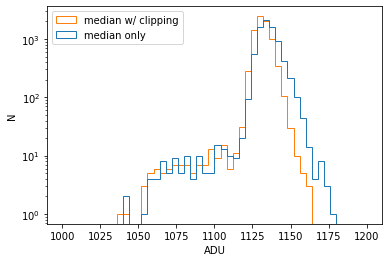

In [17]:
plt.hist([bkg_median_woclp, bkg_median], bins=50, range=(1000,1200), 
         log=True, histtype='step',
         label=['median only', 'median w/ clipping'])
plt.legend(loc='upper left')
plt.xlabel('ADU')
plt.ylabel('N')

## forced photometry

## 等級に直す

In [18]:
magzero = [28.743,28.158,27.780,27.5]

omag0 = -2.5 * np.log10(catalog['o_adu']) + magzero[0]
omag1 = -2.5 * np.log10(catalog['o0adu']) + magzero[0]
omag2 = -2.5 * np.log10(catalog['o1adu']) + magzero[0]
omag3 = -2.5 * np.log10(catalog['o2adu']) + magzero[0]
omag4 = -2.5 * np.log10(catalog['o3adu']) + magzero[0]
omag5 = -2.5 * np.log10(catalog['o4adu']) + magzero[0]

jmag0 = -2.5 * np.log10(catalog['j_adu']) + magzero[1]
jmag1 = -2.5 * np.log10(catalog['j0adu']) + magzero[1]
jmag2 = -2.5 * np.log10(catalog['j1adu']) + magzero[1]
jmag3 = -2.5 * np.log10(catalog['j2adu']) + magzero[1]
jmag4 = -2.5 * np.log10(catalog['j3adu']) + magzero[1]
jmag5 = -2.5 * np.log10(catalog['j4adu']) + magzero[1]

hmag0 = -2.5 * np.log10(catalog['h_adu']) + magzero[2]
hmag1 = -2.5 * np.log10(catalog['h0adu']) + magzero[2]
hmag2 = -2.5 * np.log10(catalog['h1adu']) + magzero[2]
hmag3 = -2.5 * np.log10(catalog['h2adu']) + magzero[2]
hmag4 = -2.5 * np.log10(catalog['h3adu']) + magzero[2]
hmag5 = -2.5 * np.log10(catalog['h4adu']) + magzero[2]

kmag0 = -2.5 * np.log10(catalog['k_adu']) + magzero[3]
kmag1 = -2.5 * np.log10(catalog['k0adu']) + magzero[3]
kmag2 = -2.5 * np.log10(catalog['k1adu']) + magzero[3]
kmag3 = -2.5 * np.log10(catalog['k2adu']) + magzero[3]
kmag4 = -2.5 * np.log10(catalog['k3adu']) + magzero[3]
kmag5 = -2.5 * np.log10(catalog['k4adu']) + magzero[3]

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## GRB候補天体選出

### 二色図を書く

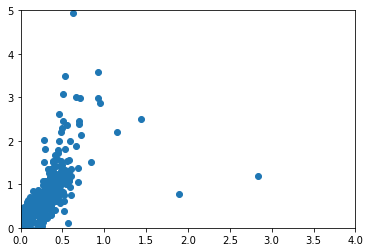

In [19]:
plt.scatter(hmag1 - kmag1, jmag1 - kmag1)
plt.xlim(0, 4)
plt.ylim(0, 5)
plt.show()

In [20]:
print(catalog)

            xref        yref    o_adu      j_adu       h_adu      k_adu  \
0       9.349894    3.348962 -999.999   -999.999    -999.999   -999.999   
1     311.992548    1.030104 -999.999  41642.003  117775.270  69105.428   
2     791.999672    0.900762 -999.999   -999.999    -999.999   -999.999   
3     484.044252  484.051720 -999.999   -999.999    -999.999   -999.999   
4     729.802110    3.194448 -999.999   -999.999    -999.999   -999.999   
...          ...         ...      ...        ...         ...        ...   
7989  755.037430  973.744550 -999.999   -999.999    -999.999   -999.999   
7990  776.630600  975.210480 -999.999   -999.999    -999.999   -999.999   
7991  869.999640  973.352520 -999.999   -999.999    -999.999   -999.999   
7992  686.179300  975.785180 -999.999   -999.999    -999.999   -999.999   
7993  715.831240  973.805460 -999.999   -999.999    -999.999   -999.999   

             o0adu         o0x         o0y         o1adu  ...         k1y  \
0      -999.999000    

## 処理時間記録表示

In [21]:
totaltime = 0.0
for data in eptime_table:
    print('{:25s}: {:8.3f}'.format(data[0], data[1]))
    totaltime += float(data[1])
print('{:25s}: {:8.3f}'.format('Total', totaltime))

Image registration       :    8.675
Combining                :    1.488
Aperture Photometry      :    9.326
Band Marging             :    0.501
Catarog Creation         :    0.588
Forced Photometry        :   54.066
Total                    :   74.645
